<a href="https://colab.research.google.com/github/tishakbhavsar/practising-pytorch/blob/main/03_pyth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.3 Computer Vision

### Computer based libraries in PyTorch

* `torchvision` : Base domain library for PyTorch Computer Vision
* `torchvision.datasets` : Get datasets and data loading functions
* `torchvision.models`: Get pretrained CV models (alr been trained on some vision data)
* `torchvision.transforms` : Functions for manipulating your vision data(images) to be suitable for use with an ML model
* `torch.utils.data.Dataset`: Base dataset class for PyTorch
* `torch.utils.data.DataLoader`: Creates a python iterable over a dataset

In [4]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor # Convert PIL image or numpy.ndarray

# import matplotlib
import matplotlib.pyplot as plt

# check versions
print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


### 1. Getting a dataset

The data we will be using is FashionMNIST! - grey scale images of clothing items (upgraded MNIST which is grey scale image data of handwritten digits).

This is a built-in dataset in torchvision.datasets ! Torch vision also has a bunch of other data sets :0

These are mostly pre-formatted to be used with PyTorch unlike your custom datasets.

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
# Training data

train_data = datasets.FashionMNIST(
    root="data", # where to download data
    train=True, # already formatted into train , if false we get Test!
    download=True, # do we want to download images? yes here
    transform=torchvision.transforms.ToTensor(), #how do we want to transform the data
    target_transform=None # how do we want to transform labels
)

# Testing data:

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform = ToTensor(),
    target_transform = None
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 20.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 340kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 6.06MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 6.59MB/s]


In [7]:
len(train_data), len(test_data)

(60000, 10000)

In [8]:
# See the first training example
image, label = train_data[0]
print(f'Image shape: {image.shape} -> [color channels, height, width]') # gray scale so c = 1(color channels first), C,W,H

Image shape: torch.Size([1, 28, 28]) -> [color channels, height, width]


In [9]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [10]:
class_to_idx = train_data.class_to_idx
class_to_idx # gives a dictionary with mapped category values!

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

### 1.2 Visualising our data

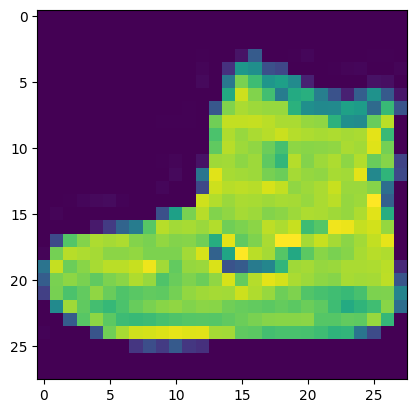

In [11]:
image, label = train_data[0]
# plt.imshow(image) # because c, w, h

#matplotlib expects color channels at last

plt.imshow(image.squeeze()) # remove extra 1 dim

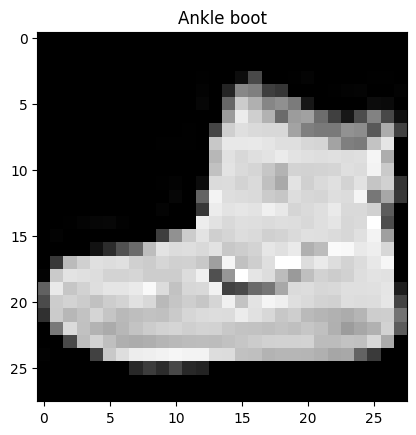

In [12]:
plt.imshow(image.squeeze(), cmap="gray");
plt.title(class_names[label]);

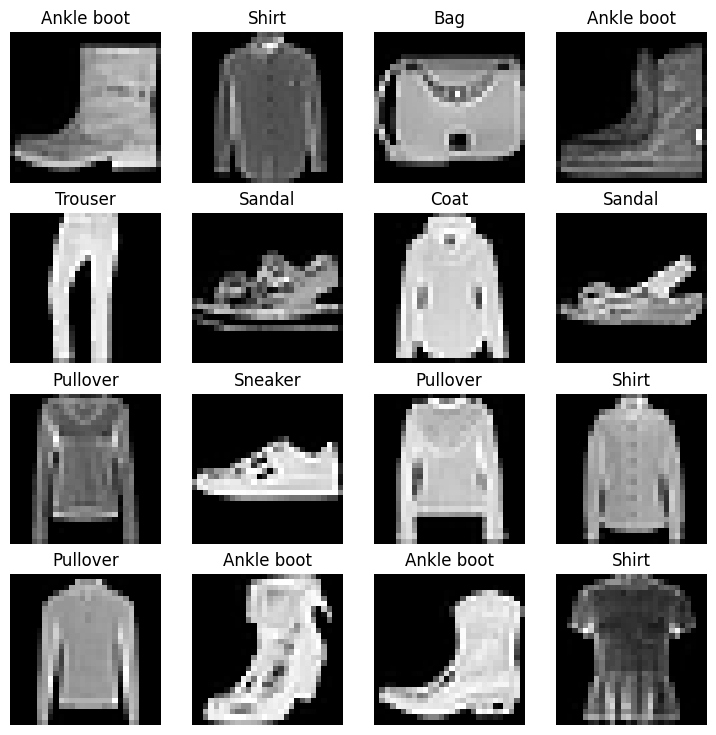

In [13]:
# Plot random images

torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4,4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0,len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

Do you think these items of clothing , could be modelled with pure linear linear or we shall need non-linearity? - the latter prob!

### 2. Prepare DataLoader

Right now, our data is in form of PyTorch datasets. We use dataloaders to convert into python iterables.


More specifically, want to turn data into batches. **But why?** Computer hardware cannot look at 60K images at a time, memory won't work. Hence, we break it into mini-batches. Because:

- It is more computationally efficient. cannot process/(store in memory) 60k images in one hit. Hence break it into looking at 32 images at a time (commonly used)

- Gives our neural network more chances to update its gradients per epoch. Instead of one update per epoch, multiple updates per epoch!

In [14]:
from torch.utils.data import DataLoader

# SET UP HYPERPARAMS

BATCH_SIZE = 32

# Turn datasets into iterables

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True) # in case data is ordered, we dont want our model to learn the order of images, just the patterns per image

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7cb3642f2850>,
 <torch.utils.data.dataloader.DataLoader at 0x7cb36430de50>)

In [15]:
print("Number of train batches of size 32:", len(train_dataloader))
print("Number of test batches of size 32:", len(test_dataloader))

Number of train batches of size 32: 1875
Number of test batches of size 32: 313


In [16]:
# Check out what is inside the training dataloader

train_features_batch, train_labels_batch = next(iter(train_dataloader)) # turn dataloader into iterable, get the next batch
train_features_batch.shape, train_labels_batch.shape #NCHW, labels for number of images in a batch, so hence 32 images

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image Size: torch.Size([1, 28, 28])
Label:6


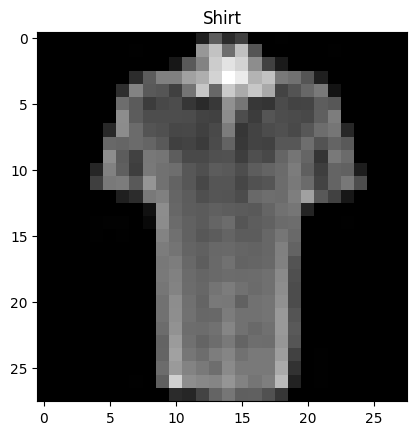

In [17]:
# Show a sample

torch.manual_seed(42)
random_idx = torch.randint(0,len(train_features_batch),size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label]);
print(f'Image Size: {img.shape}')
print(f'Label:{label}')

### 3. Model 0: Build a baseline model

Best practice to start with baseline model! It is a simple model, we can try to improve upon it. Add complexity, when necessary, start simple though.

In [18]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample

x = train_features_batch[0]
x.shape
output = flatten_model(x)
print("After flattening the image, the shape is:", output.shape)
print("We have one value per pixel.") # for each color channel it created a 28 x 28 map , h and w are flattened

After flattening the image, the shape is: torch.Size([1, 784])
We have one value per pixel.


In [19]:
# Model Class
class FashionMNISTModelV0(nn.Module):
  def __init__(self,
               input_shape:int,
               output_shape:int,
               hidden_units:int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)


In [20]:
# Instantiate a class!

torch.manual_seed(42)
model_0 = FashionMNISTModelV0(input_shape=784, # this is 28*28
                              output_shape=len(class_names),
                              hidden_units=10)

model_0.to("cpu")

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [21]:
dummy_x = torch.rand([1,1,28,28])
ans = model_0(dummy_x)
print(ans) # logit values

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)


### 3.1 Pick a loss function and optimizer

loss function -> since multi class classification, hence CrossEntropyLoss

optimizer -> stick with SGD

evaluation metric -> using accuracy!


In [22]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = correct/len(y_pred)
  return acc

In [23]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

### Creating a time function to time our code!

Machine learning is very experimental. Two things we want to track:

1. Model's performance metrics.
2. How fast it runs.


In [24]:
from timeit import default_timer  as timer

def print_train_time(start:float,
                     end:float,
                     device: torch.device=None):
  """Prints difference between start and end time."""
  total_time = end - start
  print(f"Total time on {device}: {total_time:.3f} seconds")
  return total_time

In [25]:
start_time = timer()

# some code
end_time = timer()
print_train_time(start=start_time, end=end_time, device="cpu")


Total time on cpu: 0.000 seconds


5.5195000015828555e-05

### 3.3 Creating trainin loop and training a model on batches of data

1. loop thru epochs
2. loop thru training batches, perform training steps, calc train loss PER BATCH
3. loop thru testing batch! calc test loss PER BATCH AS WELL
4. print status
5. time it

In [26]:
device

'cpu'

In [27]:
# for python progress bar

from tqdm.auto import tqdm # auto recognises system, so it looks at it and then gives us progress bar accordingly

# set seed and start timer

torch.manual_seed(42)
train_time_start_on_cpu = timer()

# set no of epochs - keep small rn

epochs = 3

# create loop for training
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n-------------')

    ## training
    train_loss = 0 # set zero for every batch
    for batch, (X,y) in enumerate(train_dataloader):
      model_0.train() # put model in train mode
      y_pred = model_0(X) # forward pass

      loss = loss_fn(y_pred, y)
      train_loss += loss # total loss per batch
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if batch % 400 == 0:
        print(f'Looked at {batch*len(X)}/{len(train_dataloader.dataset)} samples')
    # adjust train loss to get average training loss per batch, divide total train loss by len of train dataloader
    train_loss /= len(train_dataloader) #avg loss per epoch/ per batch

    ## testing
    test_loss, test_acc = 0,0
    model_0.eval()
    with torch.inference_mode():
      for X_test,y_test in test_dataloader:
        test_pred = model_0(X_test)
        test_loss += loss_fn(test_pred, y_test)
        test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))
      # Calc test loss average per batch
      test_loss /= len(test_dataloader)
      # Calc test acc average per batch
      test_acc /= len(test_dataloader)
    print(f'\nTrain Loss: {train_loss:.5f} | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.5f}')

train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, end=train_time_end_on_cpu, device = str(next(model_0.parameters()).device))
print("Total Time:", total_train_time_model_0)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.59039 | Test Loss: 0.50954 | Test Acc: 0.82039
Epoch: 1
-------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.47633 | Test Loss: 0.47989 | Test Acc: 0.83197
Epoch: 2
-------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.45503 | Test Loss: 0.47664 | Test Acc: 0.83427
Total time on cpu: 32.605 seconds
Total Time: 32.60520257899998


In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### 4. Make Predictions and get Model 0 results

In [29]:
torch.manual_seed(42)
def eval_model(model : torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               accuracy_fn):
  """ Returns a dictionary containing the results of model predicting on data_loader."""
  loss, acc = 0,0
  model.eval()
  with torch.inference_mode():
    for X,y in tqdm(data_loader):
      # X,y = X.to(device), y.to(device)
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    loss/=len(data_loader)
    acc/=len(data_loader)
  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc:": acc}

model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn = nn.CrossEntropyLoss(),
                             accuracy_fn = accuracy_fn)
model_0_results



  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc:': 0.8342651757188498}

In [30]:
# Set up device agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

#### Do we need non-linearity? Let us use that!

In [31]:
# Model Class - with non-linearity
class FashionMNISTModelV1(nn.Module):
  def __init__(self,
               input_shape:int,
               output_shape:int,
               hidden_units:int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape),
        nn.ReLU()
    )

  def forward(self, x):
    return self.layer_stack(x)

In [32]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784,
                              output_shape=len(class_names),
                              hidden_units=10).to(device)

In [33]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = correct/len(y_pred)
  return acc

#### Training loop!

In [34]:
def train_step(model: torch.nn.Module,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               data_loader: torch.utils.data.DataLoader,
               accuracy_fn,
               device: torch.device = device):
  """Performs a training with model trying to learn on data_loader."""
  # Put model into training mode
  model.train()
  train_loss, train_acc = 0,0
  for batch, (X,y) in enumerate(data_loader):
      X,y = X.to(device), y.to(device)
      y_pred = model(X) # forward pass
      loss = loss_fn(y_pred, y)
      train_loss += loss # total loss per batch
      train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1)) #from logits to pred labels
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if batch % 400 == 0:
        print(f'Looked at {batch*len(X)}/{len(train_dataloader.dataset)} samples')
    # adjust train loss to get average training loss per batch, divide total train loss by len of train dataloader
  train_loss /= len(data_loader) #avg loss per epoch/ per batch
  train_acc /= len(data_loader)
  print(f'\nTrain Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.5f}')


In [35]:
def test_step(model: torch.nn.Module,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               data_loader: torch.utils.data.DataLoader,
               accuracy_fn,
               device: torch.device = device):
  """Performs a testing with model trying to learn on data_loader."""
  # Put model into training mode
  model.eval()
  test_loss, test_acc = 0,0
  with torch.inference_mode():
    for X,y in data_loader:
        X,y = X.to(device), y.to(device)
        test_pred = model(X) # forward pass
        test_loss += loss_fn(test_pred, y)# total loss per batch
        test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1)) #from logits to pred labels
    test_loss /= len(data_loader) #avg loss per epoch/ per batch
    test_acc /= len(data_loader)
    print(f'\nTest Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.5f}')


In [36]:
torch.manual_seed(42)
train_time_start_on_gpu = timer()
epochs = 3
for epoch in range(epochs):
  # Just call each functions
  train_step(model_1, loss_fn, optimizer, train_dataloader, accuracy_fn, device)
  test_step(model_1, loss_fn, optimizer, test_dataloader, accuracy_fn, device)
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu, end=train_time_end_on_gpu, device = str(next(model_0.parameters()).device))

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train Loss: 1.09199 | Train Accuracy: 0.61343

Test Loss: 0.95636 | Test Accuracy: 0.64996
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.78101 | Train Accuracy: 0.71928

Test Loss: 0.72227 | Test Accuracy: 0.73912
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.67027 | Train Accuracy: 0.75937

Test Loss: 0.68500 | Test Accuracy: 0.75020
Total time on cpu: 33.997 seconds


In [37]:
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn = nn.CrossEntropyLoss(),
                             accuracy_fn = accuracy_fn)
model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850009560585022,
 'model_acc:': 0.7501996805111821}

### Why did we do worse :0 ?

1. It could be that the overhead for copying data/model to and from the GPU outweights the compute benefits offered by the GPU.

2. The hardware you'r using has a better CPU in terms of compute capability than the GPU.

## Convolutional Neural Networks

https://poloclub.github.io/cnn-explainer/

Deep CNNs are made up of multiple convolutional blocks.

In [38]:
# Create a CNN

class FashionMNISTModelV2(nn.Module):
  """
  Model architecture that replicates the TinyVGG architecture.
  """
  def __init__(self, input_shape:int, output_shape:int, hidden_units:int):
    super().__init__() # initializer
    self.conv_block = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1), # values we can set -> hyperparamters
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, # there is a trick to calculate this
                  out_features = output_shape)
    )
  def forward(self, x):
    x = self.conv_block(x)
    # print(f'Output shape of Conv block 1: {x.shape}')
    x = self.conv_block_2(x)
    # print(f'Output shape of Conv block 2: {x.shape}')
    x = self.classifier(x)
    # print(f'Output shape of classifier: {x.shape}')
    return x


In [39]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape = 1,
                              output_shape = len(class_names),
                              hidden_units = 10)
 # single image color channel hence input shape is one

model_2.to(device)

FashionMNISTModelV2(
  (conv_block): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

### 7. 1 Stepping through nn.Conv2d

See the documentation : https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

In [40]:
torch.manual_seed(42)

images = torch.randn(32,3,64,64) # 3 color channels
test_image = images[0]
test_image.shape

torch.Size([3, 64, 64])

#### 1. First CONV layer

In [41]:
# Create a single conv2d layer
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=1)

In [42]:
conv_layer_output = conv_layer(test_image.unsqueeze(dim=0))
conv_layer_output.shape

torch.Size([1, 10, 64, 64])

#### 2. Applying ReLU

In [43]:
relu_layer = nn.ReLU()
relu_output = relu_layer(conv_layer_output)
relu_output.shape

torch.Size([1, 10, 64, 64])

#### 3. Second Conv

In [44]:
conv_layer_2 = nn.Conv2d(in_channels=10,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=1)

In [45]:
conv_layer_2_output = conv_layer_2(relu_output)
conv_layer_2_output.shape

torch.Size([1, 10, 64, 64])

#### 4. Applying Maxpool

In [46]:
max_pool = nn.MaxPool2d(kernel_size=2)
max_pool_output = max_pool(conv_layer_2_output)
max_pool_output.shape

torch.Size([1, 10, 32, 32])

#### 5. Repeating the same steps!

In [47]:
conv_layer_3_output = conv_layer_2(max_pool_output)
print(conv_layer_3_output.shape)
relu_output_2 = relu_layer(conv_layer_3_output)
print(relu_output_2.shape)
conv_layer_4_output = conv_layer_2(relu_output_2)
print(conv_layer_4_output.shape)
max_pool_output_2 = max_pool(conv_layer_4_output)
print(max_pool_output_2.shape)

torch.Size([1, 10, 32, 32])
torch.Size([1, 10, 32, 32])
torch.Size([1, 10, 32, 32])
torch.Size([1, 10, 16, 16])


#### 6. Applying Fully Connected Classifier at the end

In [48]:
classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=10*16*16, # there is a trick to calculate this
                  out_features = len(class_names))
    )

classifier_output = classifier(max_pool_output_2)
classifier_output = classifier_output.squeeze(dim=0)

#### 7. Outputs

In [49]:
logits = classifier_output
y_pred_probs = torch.softmax(logits,dim=0)
y_pred_label = torch.argmax(y_pred_probs)
print("Logits: ")
print(logits)
print("After softmax: ")
print(y_pred_probs)
print("After argmax: ")
print(y_pred_label.item())

Logits: 
tensor([-0.0123,  0.0558,  0.1293,  0.0582,  0.0393, -0.0193,  0.0087, -0.0114,
         0.0271, -0.0717], grad_fn=<SqueezeBackward1>)
After softmax: 
tensor([0.0967, 0.1035, 0.1114, 0.1037, 0.1018, 0.0960, 0.0987, 0.0967, 0.1005,
        0.0911], grad_fn=<SoftmaxBackward0>)
After argmax: 
2


### Applying the Model

In [50]:
image.shape

torch.Size([1, 28, 28])

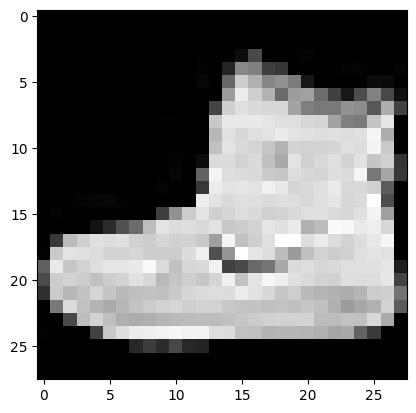

In [51]:
plt.imshow(image.squeeze(), cmap="gray");

In [52]:
rand_image_tensor = torch.randn(size=(1,28,28))
rand_image_tensor.shape

torch.Size([1, 28, 28])

In [53]:
logits = model_2(rand_image_tensor.unsqueeze(0).to(device))

In [54]:
logits = logits.squeeze(dim=0)
print(logits)

tensor([ 0.0376, -0.0941,  0.0684, -0.0351,  0.0070,  0.0274, -0.0075,  0.0132,
        -0.0083, -0.0192], grad_fn=<SqueezeBackward1>)


### Let us pass actual data in our CNN

In [55]:
# Set up loss function

loss_fn = nn.CrossEntropyLoss()

# Set up optimizer

optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

accuracy_fn = accuracy_fn

### Training and testing model_2 using train and test functions

In [56]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
train_time_start_model_2 = timer()

epochs = 3
for epoch in range(epochs):
  print(f'Epoch: {epoch} -------------')
  train_step(model=model_2,
             loss_fn=loss_fn,
             optimizer=optimizer,
             data_loader=train_dataloader,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_2,
            loss_fn=loss_fn,
            optimizer=optimizer,
            data_loader=test_dataloader,
            accuracy_fn = accuracy_fn,
            device=device)

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2, end=train_time_end_model_2, device = device)

Epoch: 0 -------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.59518 | Train Accuracy: 0.78375

Test Loss: 0.39500 | Test Accuracy: 0.85992
Epoch: 1 -------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.36536 | Train Accuracy: 0.86902

Test Loss: 0.35244 | Test Accuracy: 0.86911
Epoch: 2 -------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.32588 | Train Accuracy: 0.88128

Test Loss: 0.32719 | Test Accuracy: 0.88069
Total time on cpu: 185.549 seconds


In [57]:
model_2_results = eval_model(model=model_2,
                             data_loader=test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn = accuracy_fn)

  0%|          | 0/313 [00:00<?, ?it/s]

In [58]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.32718968391418457,
 'model_acc:': 0.8806908945686901}

### 8. Compare results and training time!


In [59]:
import pandas as pd

In [60]:
compare_results = pd.DataFrame([model_0_results,model_1_results, model_2_results])

In [61]:
compare_results['training_time'] = [total_train_time_model_0, total_train_time_model_1, total_train_time_model_2]

In [62]:
compare_results

,model_name,model_loss,model_acc:,training_time
0,FashionMNISTModelV0,0.476639,0.834265,32.605203
1,FashionMNISTModelV1,0.685001,0.750200,33.996868
2,FashionMNISTModelV2,0.327190,0.880691,185.549305


### Visualise our model results

Text(0, 0.5, 'Model')

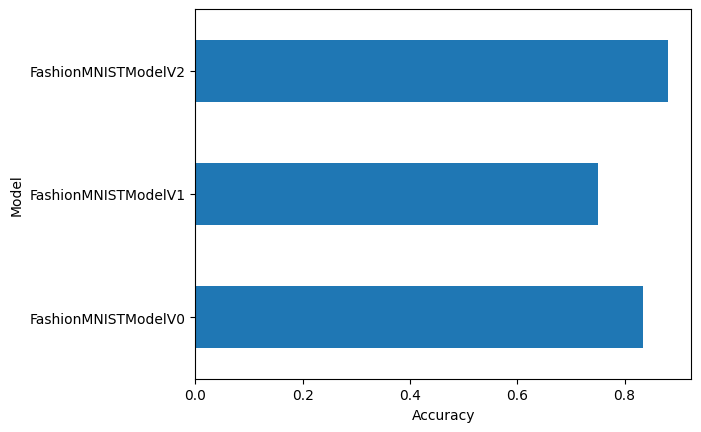

In [63]:
compare_results.set_index("model_name")["model_acc:"].plot(kind="barh")
plt.xlabel("Accuracy")
plt.ylabel("Model")

In [64]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


### 9. Make and evaluate random predictions with best model

In [65]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample - add batch size dimension and pass to target device
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forward pass (model output raw logits)
      pred_logit = model(sample)

      # Softmax

      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      # get pred_prob off the GPU for further calculations
      pred_probs.append(pred_prob.cpu())
  return torch.stack(pred_probs)


In [66]:
import random
# random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

# Viewe the first sample shape
test_samples[0].shape

torch.Size([1, 28, 28])

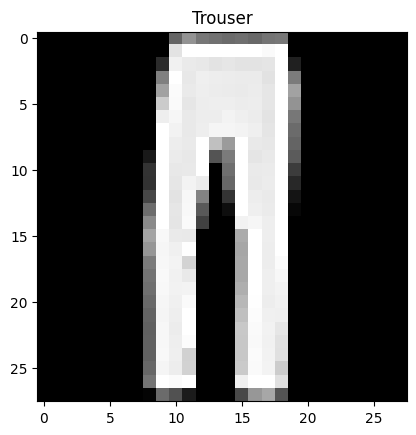

In [67]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]]);

#### Make predictions

In [68]:
pred_probs = make_predictions(model = model_2,
                              data = test_samples)
pred_probs[:2]

tensor([[1.7257e-05, 9.9985e-01, 4.6923e-07, 1.0760e-04, 1.0879e-05, 6.7349e-06,
         2.6721e-06, 9.1443e-07, 7.8286e-06, 2.4000e-07],
        [3.8393e-01, 2.3399e-05, 4.0611e-03, 1.2582e-02, 7.6826e-02, 9.6567e-07,
         5.1492e-01, 1.9666e-05, 7.6370e-03, 1.3341e-06]])

In [69]:
# Convert prediction probabilities into labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([1, 6, 8, 4, 5, 5, 4, 5, 4])

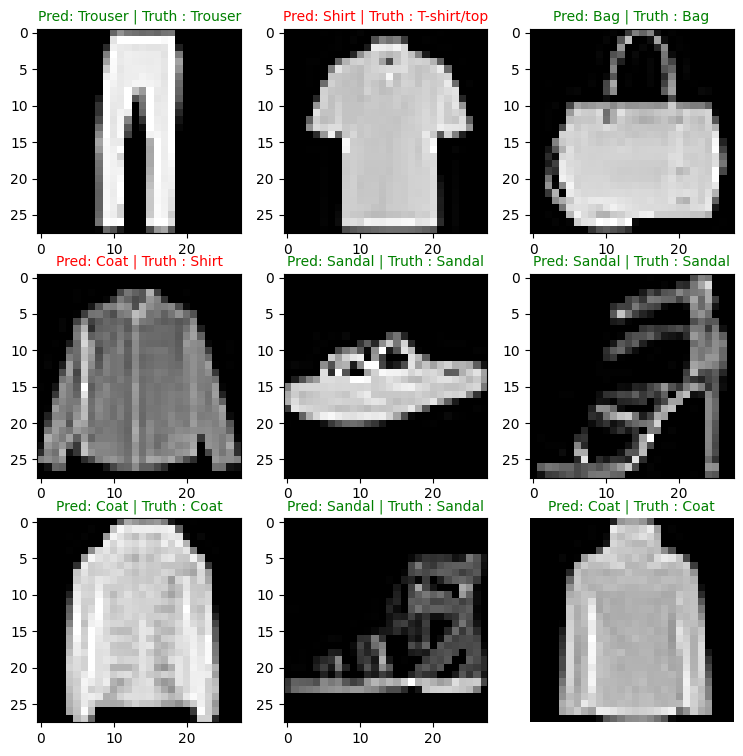

In [70]:
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create subplot
  plt.subplot(nrows,ncols,i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction
  pred_label = class_names[pred_classes[i]]

  truth_label = class_names[test_labels[i]]

  title_text = f"Pred: {pred_label} | Truth : {truth_label}"
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c='g')
  else:
        plt.title(title_text, fontsize=10, c='r')

plt.axis(False);

### 10. Making a confusion matrix

1. Make predictions
2. Use `torchmetrics`
3. Plot the confusion matrix using `mlxtend.plotconfusion matirx`


In [71]:
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_2.to(device)
model_2.eval()
with torch.inference_mode():
  for X,y in tqdm(test_dataloader, desc="Making predictions..."):
    # Send data on device
    X,y = X.to(device), y.to(device)
    # Forward pass
    y_logit = model_2(X)
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds) # turn list into single tensor

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

In [72]:
import mlxtend
import torchmetrics



'0.23.4'

In [74]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [76]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. set up instance of CM

cm = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
cm_tensor = cm(preds=y_pred_tensor, target=test_data.targets)
cm_tensor

tensor([[628,   5,  44,  79,  12,   1, 224,   0,   7,   0],
        [  8, 895,   7,  68,  13,   0,   5,   0,   3,   1],
        [  7,   1, 810,  13,  95,   0,  69,   0,   5,   0],
        [ 25,  13,  25, 861,  36,   0,  34,   0,   4,   2],
        [  5,   6, 117,  50, 712,   0, 106,   0,   4,   0],
        [  6,   0,   9,  11,   0, 840,   4,  44,  66,  20],
        [ 69,   7, 123,  64,  98,   0, 626,   0,  13,   0],
        [  1,   1,   0,   1,   0,  33,   0, 877,  18,  69],
        [  8,   2,  23,  17,   6,   7,  29,   7, 900,   1],
        [  1,   0,   1,   2,   0,  20,   4,  71,  11, 890]])

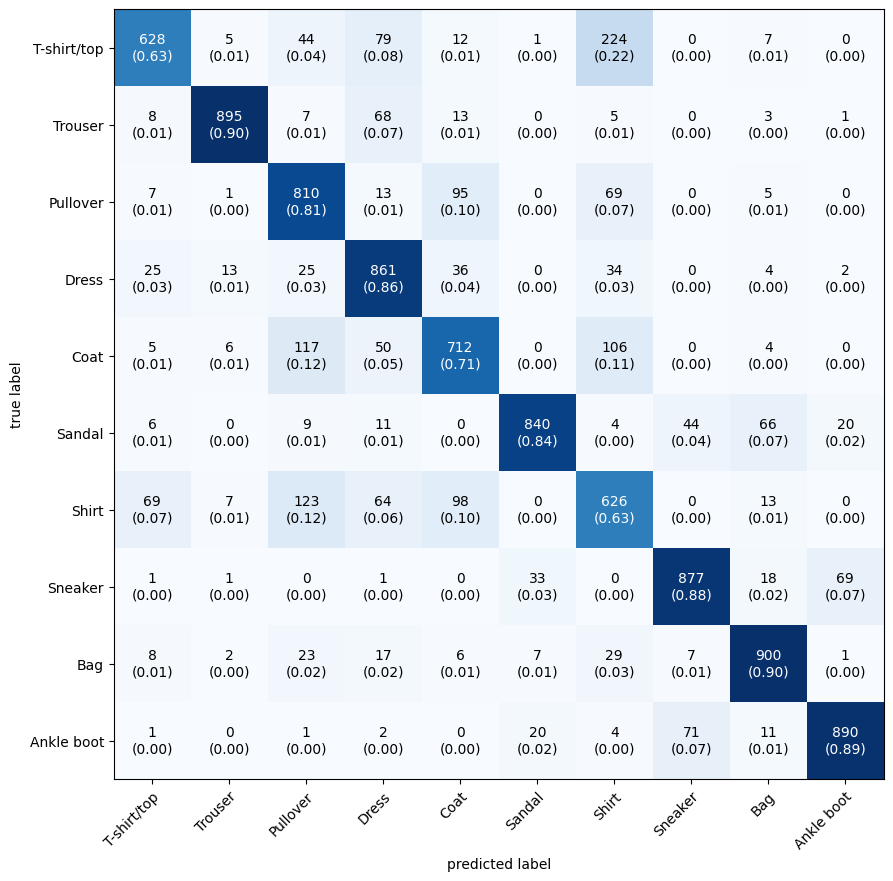

In [78]:
# 3. plot the confusion matrix

fig, ax = plot_confusion_matrix(
    conf_mat=cm_tensor.numpy(),
    figsize=(10,10),
    class_names=class_names,
    show_normed=True
)

### 11. Saving and Loading the Model

In [79]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "03_computer_vision_CNN.pth"

MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

# Save the state dict of model
print(f'Saving the model to: {MODEL_SAVE_PATH}')
torch.save(obj=model_2.state_dict(), f=MODEL_SAVE_PATH)

Saving the model to: models/03_computer_vision_CNN.pth


In [80]:
torch.manual_seed(42)

loaded_model_2 = FashionMNISTModelV2(input_shape=1,
                                     hidden_units=10,
                                     output_shape=len(class_names))
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model_2.to(device)

FashionMNISTModelV2(
  (conv_block): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [82]:
loaded_model_2_results = eval_model(loaded_model_2,test_dataloader,loss_fn,accuracy_fn)
loaded_model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.32718968391418457,
 'model_acc:': 0.8806908945686901}

In [84]:
torch.isclose(torch.tensor(model_2_results['model_loss']), torch.tensor(loaded_model_2_results['model_loss']))

tensor(True)